In [1]:
# import time
import os
from skimage import io
import scipy as sp
import numpy as np
# import sys
import openpnm as op
import porespy as ps
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import rcParams
np.set_printoptions(precision=4)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import math
import pickle
import seaborn as sns

In [2]:
# Matplotlib plotting controls

params = {'figure.autolayout': True,
          'figure.titleweight': 'normal',
          'lines.markersize': 8,
          'lines.markeredgewidth': 1,
          'lines.linewidth': 2,
          'font.weight': 'normal',
          'font.size': 14,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'legend.fontsize': 12,
          'legend.title_fontsize':12,
          'figure.figsize': (6, 5),
          'figure.titlesize': 14,
          'axes.labelsize': 12,
          'axes.labelweight': 'normal',
          'axes.titlesize': 14,
          'axes.linewidth': 1,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labeltop': False,
          'xtick.labelbottom': True,
          'ytick.left': True,
          'ytick.right': True,
          'ytick.labelright': False,
          'ytick.labelleft': True,
          'ytick.major.size': 5.5,
          'ytick.major.width': 0.8,
          'xtick.major.size': 5.5,
          'xtick.major.width': 0.8,
          'ytick.minor.size': 3.5,
          'ytick.minor.width': 0.6,
          'xtick.minor.size': 3.5,
          'xtick.minor.width': 0.6,
        'xtick.minor.visible':True,
         'ytick.minor.visible':True,
         'savefig.dpi': 1000,
        #  'text.usetex':False
         }
rcParams.update(params)

In [3]:
path = './data/1p2um volumes/'

with open(path+"snow_solid_1p2um_networks.pkl", "rb") as f:
    snow_solid_networks = pickle.load(f)

with open(path+"snow_void_1p2um_networks.pkl", "rb") as f:
    snow_void_networks = pickle.load(f)

snow_total_networks = [snow_solid_networks,snow_void_networks]

# Water retention curves - old - testing 

In [4]:
#Create OpenPNM project objects
pn_solid = []
pn_void = []

for x in snow_solid_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_solid.append(pn_temp)
    
for x in snow_void_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_void.append(pn_temp)
    

pn_total = [pn_solid, pn_void]


In [5]:
test_snow = snow_total_networks[1][1][1]
test_region = pn_total[1][1][1]


print('pore volume:')
print(test_snow['pore.volume'])
print(test_snow['pore.region_volume'])
test_volume = op.models.geometry.pore_volume.sphere(test_snow,pore_diameter='pore.equivalent_diameter')
test_volume = test_snow['pore.equivalent_diameter']**3 * np.pi/6
print(test_volume)
print()

print('pore surface area:')
print(test_snow['pore.surface_area'])
test_pore_surface_area = op.models.geometry.pore_surface_area.sphere(test_region,pore_diameter='pore.equivalent_diameter')
print(test_pore_surface_area)
print()


pore volume:
[5.8752e-23 1.1858e-22 5.3486e-21 ... 1.2312e-23 4.3416e-23 3.8880e-24]
[5.8752e-23 1.1858e-22 5.3486e-21 ... 1.2312e-23 4.3416e-23 3.8880e-24]
[5.8752e-23 1.1858e-22 5.3486e-21 ... 1.2312e-23 4.3416e-23 3.8880e-24]

pore surface area:
[3.8520e-15 6.4800e-15 3.6432e-14 ... 1.8360e-15 6.1560e-15 6.4800e-16]
[5.2206e-15 4.7966e-15 0.0000e+00 ... 1.8945e-15 3.5618e-15 9.7974e-16]



In [6]:
test_region = pn_total[1][1][1]

print('throat length')
print(test_region['throat.total_length'])
conduit_lengths = op.models.geometry.conduit_lengths.cones_and_cylinders(test_region,
    pore_diameter='pore.equivalent_diameter',throat_diameter = 'throat.inscribed_diameter')
test_throat_length = conduit_lengths[:,1]
print(test_throat_length)
print()

# print('diffusive_size_factors')
# print(test_geo['throat.diffusive_size_factors.pore1'])
# diffusive_size_factors = op.models.geometry.diffusive_size_factors.cones_and_cylinders(test_geo)
# print(diffusive_size_factors['pore1'])


print(test_region)

throat length
[6.9358e-08 5.0318e-08 4.2017e-08 ... 2.4888e-08 2.5995e-08 1.8637e-08]
[1.1169e-08 1.0000e-15 1.0000e-15 ... 1.0000e-15 1.0000e-15 1.0000e-15]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x17c514680>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  2159 / 2159
  3  pore.coords                                                   1194 / 1194
  4  pore.region_label                                             1194 / 1194
  5  pore.phase                                                    1194 / 1194
  6  throat.phases                                                 2159 / 2159
  7  pore.region_volume                                            1194 / 1194
  8

In [7]:
for s,sample in enumerate(pn_total[1]):
    for r,region in enumerate(sample):

        h = op.utils.check_network_health(region)
        op.topotools.trim(network=region, pores=h['disconnected_pores'])
        region.regenerate_models()


        region['pore.diameter'] = region['pore.extended_diameter']
        region['throat.diameter'] = region['throat.inscribed_diameter']
        
        region.add_model(propname='throat.coords',model=op.models.geometry.throat_centroid.pore_coords)
       
        region.add_model(propname='throat.length',model=op.models.geometry.throat_length.hybrid_cones_and_cylinders)
        region.add_model(propname='throat.volume',model=op.models.geometry.throat_volume.cylinder)

        region.regenerate_models()

In [8]:
phases = []       
for s,sample in enumerate(pn_total[1]):
        sample_phases = []
        for r,region in enumerate(sample):
                phase = op.phase.Phase(network=region, name='phase_{}_{}'.format(s,r))
                phase['pore.contact_angle'] =  105  
                phase['pore.surface_tension'] = 0.0626 
                # phase['throat.contact_angle'] =  105
                # phase['throat.surface_tension'] = 0.0626
                
                phase.add_model(propname='throat.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                                surface_tension='throat.surface_tension',
                                contact_angle='throat.contact_angle',
                                diameter='throat.diameter'
                                )
                phase.add_model(propname='pore.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                                surface_tension='pore.surface_tension',
                                contact_angle='pore.contact_angle',
                                diameter='pore.diameter'
                                )
                phase.regenerate_models()

                sample_phases.append(phase)
        phases.append(sample_phases)



In [9]:
print(phases[0][0]['throat.contact_angle'])
print(phases[0][0]['throat.surface_tension'])

[105. 105. 105. ... 105. 105. 105.]
[0.0626 0.0626 0.0626 ... 0.0626 0.0626 0.0626]


In [10]:
percs = []
drains = []
pressures = np.logspace(4,7,100)

for s,sample in enumerate(pn_total[1]):
    sample_percs = []
    sample_drains = []
    for r,region in enumerate(sample):

        inlets = region.pores('ymax')
        used_inlets = [inlets[y] for y in range(0, len(inlets), 1)]
        op.algorithms.InvasionPercolation(network=region,phase=phases[s][r]).reset()
        perc = op.algorithms.InvasionPercolation(network=region,phase=phases[s][r],name='perc_{}_{}'.format(s,r))
        perc.set_inlet_BC(pores = used_inlets)
        perc.run()


        inlets = region.pores('ymax')
        used_inlets = [inlets[y] for y in range(0, len(inlets), 1)]
        op.algorithms.Drainage(network=region,phase=phases[s][r]).reset()
        drain = op.algorithms.Drainage(network=region,phase=phases[s][r],name='drain_{}_{}'.format(s,r))
        drain.set_inlet_BC(pores = used_inlets)
        drain.run(pressures=pressures)

        sample_percs.append(perc)
        sample_drains.append(drain)
    percs.append(sample_percs)
    drains.append(sample_drains)

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
print(drains[0][0])


══════════════════════════════════════════════════════════════════════════════
drain_0_0 : <openpnm.algorithms.Drainage at 0x17d773650>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.invasion_pressure                                        1669 / 1669
  3  throat.invasion_pressure                                      3281 / 3281
  4  pore.invasion_sequence                                        1669 / 1669
  5  throat.invasion_sequence                                      3281 / 3281
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.all                                                            

In [12]:
perc_pcs = []
perc_sats = []
for s,sample in enumerate(percs):
    sample_pcs = []
    sample_sats = []
    for r,region in enumerate(sample):
        region_pc = []
        region_sat_tot = []

        pc = region.pc_curve().pc
        sat = region.pc_curve().snwp

        region_sat_tot.append(sat[0]) 
        region_pc.append(pc[0])
        for i,x in enumerate(sat):
            if  sat[i] - region_sat_tot[-1] > 0.0:
                region_pc.append(pc[i])
                region_sat_tot.append(sat[i])
        sample_pcs.append(region_pc)
        sample_sats.append(region_sat_tot)
    perc_pcs.append(sample_pcs)
    perc_sats.append(sample_sats)

In [13]:
drain_pcs = []
drain_sats = []
for s,sample in enumerate(drains):
    sample_pcs = []
    sample_sats = []
    for r,region in enumerate(sample):
        region_pc = []
        region_sat_tot = []

        pc = region.pc_curve().pc
        sat = region.pc_curve().snwp

        region_sat_tot.append(sat[0]) 
        region_pc.append(pc[0])
        for i,x in enumerate(sat):
            if  sat[i] - region_sat_tot[-1] > 0.0:
                region_pc.append(pc[i])
                region_sat_tot.append(sat[i])
        sample_pcs.append(region_pc)
        sample_sats.append(region_sat_tot)
    drain_pcs.append(sample_pcs)
    drain_sats.append(sample_sats)

In [14]:
print(drain_pcs[0][0])
print(len(drain_pcs[0][0]))

[305385.55088334123, 351119.17342151277, 376493.58067924716, 403701.72585965577, 432876.12810830615, 464158.8833612782, 497702.35643321136, 533669.9231206313, 572236.765935022, 613590.7273413176, 657933.2246575683, 705480.2310718645, 756463.3275546291, 811130.8307896872, 869749.0026177834, 932603.3468832199, 1000000.0, 1072267.222010323, 1149756.9953977356, 1232846.7394420658, 1321941.1484660287, 1417474.1629268047, 1519911.0829529332, 1629750.834620647, 1747528.4000076829, 1873817.4228603868, 2009233.0025650458, 2310129.700083158, 2477076.355991714, 2848035.8684358047, 3274549.1628777315, 4037017.2585965497, 5722367.65935022]
33


In [15]:
#log normal mean (diam [nm])
ln_mu_diam = np.array([4.6565,4.9255,4.5715])
#log normal std (same for diam or radius)
ln_sigma = np.array([0.6352,0.7396,0.6127])

ln_mu_rad = np.log(np.exp(ln_mu_diam)/2)
print('ln_mu_rad: ',ln_mu_rad)

rm = np.exp(ln_mu_rad + (ln_sigma**2/2))*10**-9
print('Rm: ',rm)

pcap = np.logspace(4,7,100)*1
gamma = 0.0626
theta = 105

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap


ln_mu_rad:  [3.9634 4.2324 3.8784]
Rm:  [6.4399e-08 9.0546e-08 5.8326e-08]


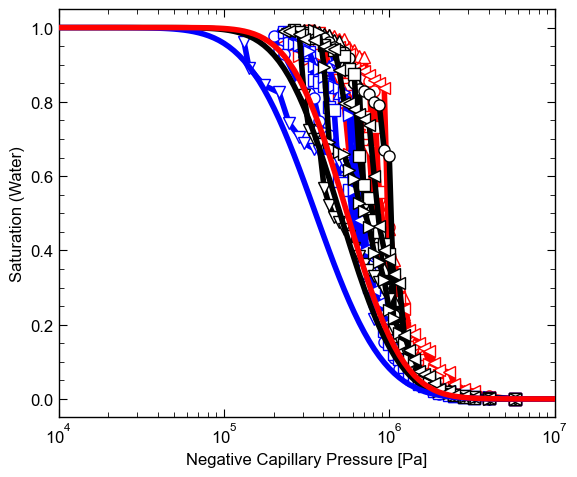

In [16]:
fig, ax = plt.subplots()

line_colors =['k','b','r']
shapes = ['^','o','s','v','>','<']
zorders = [100,99,98]

for s,sample in enumerate(perc_pcs):
    for r,region in enumerate(sample):
        # if s==1 and r==4:
        if True:
            # ax.plot(region,1-np.array(perc_sats[s][r]),color = line_colors[s], marker = shapes[r], 
            #         markeredgewidth=0.5, markerfacecolor='white',zorder=zorders[s])
            ax.plot(drain_pcs[s][r],1-np.array(drain_sats[s][r]),linewidth=4,color = line_colors[s], marker = shapes[r], 
                    markeredgewidth=1,markersize=8, markerfacecolor='white',zorder=zorders[s])
            


for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*1,s,color=line_colors[i], linewidth=4,zorder=200)

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**7, 10**4])
ax.invert_xaxis()
plt.tick_params(axis='x', which='minor')



In [17]:
#interpolation to average water retention curves for each sample across regions

x_interp = []
y_interp = []

x_all = []
f_avg = []

drain_pcs_cut = drain_pcs.copy()
drain_sats_cut = drain_sats.copy()

for s,sample in enumerate(drain_pcs_cut):
    sample_x_data = []
    sample_y_data = []
    sample_x_min_vals = []
    sample_x_max_vals = []
    sample_interp_funcs = []
    for r,region in enumerate(sample):
        sample_x_data.append(region)
        sample_y_data.append(drain_sats_cut[s][r])
        sample_x_max_vals.append(max(region))
        sample_x_min_vals.append(min(region))
        sample_interp_funcs.append(interp1d(region, drain_sats_cut[s][r]))
        
    x_max = math.floor(min(sample_x_max_vals))
    x_min = math.ceil(max(sample_x_min_vals))
    
    # define common carrier for calculation of average curve
    sample_x_all   = np.geomspace(x_min, x_max, num=50)
    
    sample_f_int = []
    for r,region in enumerate(sample):
        # evaluation of fits on common carrier
        sample_f_int.append(sample_interp_funcs[r](sample_x_all))
        
    # put all fits to one matrix for fast mean calculation
    data_collection = np.vstack(sample_f_int)

    # calculating mean value
    sample_f_avg = np.average(data_collection, axis=0)

    x_interp.append(sample_x_data)
    y_interp.append(sample_y_data)
    x_all.append(sample_x_all)
    f_avg.append(sample_f_avg)


Text(0.5, 1.0, '')

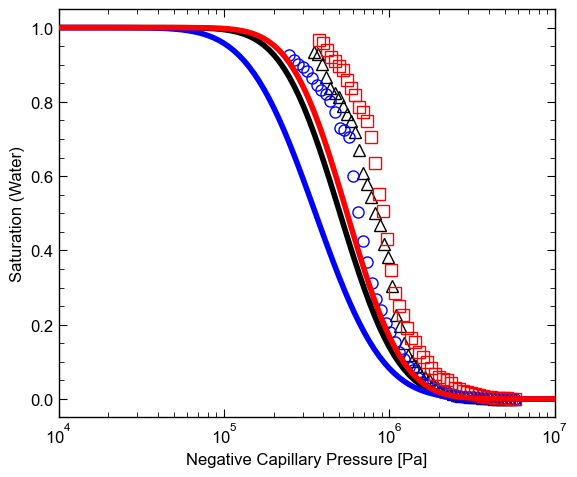

In [18]:
fig, ax = plt.subplots()

colors =['k','b','r']
shapes = ['^','o', 's']

for s,sample in enumerate(f_avg):
    ax.plot(x_all[s],1-np.array(f_avg[s]),' ',color=colors[s], marker=shapes[s], markerfacecolor='none')

pcap = np.logspace(4,7,100)*1
gamma = 0.0626
theta = 105

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap

for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*1,s,color=line_colors[i], linewidth=4,zorder=200)

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**7, 10**4])
ax.invert_xaxis()
plt.tick_params(axis='x', which='minor')
plt.title('')


In [19]:
def average_curves(x_list, y_list, num_points=200):
    """
    Average multiple x,y datasets with mismatched x-values.

    Parameters
    ----------
    x_list : list of 1D arrays
        List of x-data arrays (each curve).
    y_list : list of 1D arrays
        List of y-data arrays (same length as x_list).
    num_points : int
        Number of points in the common x-grid.

    Returns
    -------
    x_common : 1D array
        Common x-grid.
    y_mean : 1D array
        Mean of interpolated curves.
    y_std : 1D array
        Standard deviation of interpolated curves.
    """

    # Determine global x-range across all curves
    xmin = max(min(x) for x in x_list)  # restrict to overlap region
    xmax = min(max(x) for x in x_list)

    # Create common x-grid
    x_common = np.linspace(xmin, xmax, num_points)

    # Interpolate each curve
    interpolated = []
    for x, y in zip(x_list, y_list):
        f = interp1d(x, y, kind="linear", bounds_error=False, fill_value=np.nan)
        interpolated.append(f(x_common))

    interpolated = np.vstack(interpolated)

    # Compute mean and std, ignoring NaNs
    y_mean = np.nanmean(interpolated, axis=0)
    y_std = np.nanstd(interpolated, axis=0)

    return x_common, y_mean, y_std

In [20]:
def average_curves_union(x_list, y_list, num_points=200):
    """
    Average multiple x,y datasets with mismatched x-values.
    Uses the full union of x-ranges.

    Parameters
    ----------
    x_list : list of 1D arrays
        List of x-data arrays (each curve).
    y_list : list of 1D arrays
        List of y-data arrays (same length as x_list).
    num_points : int
        Number of points in the common x-grid.

    Returns
    -------
    x_common : 1D array
        Common x-grid (union of ranges).
    y_mean : 1D array
        Mean of interpolated curves (ignores NaNs).
    y_std : 1D array
        Standard deviation of interpolated curves (ignores NaNs).
    """

    # Full union range
    xmin = min(min(x) for x in x_list)
    xmax = max(max(x) for x in x_list)

    # Common x-grid
    x_common = np.linspace(xmin, xmax, num_points)

    # Interpolate each curve
    interpolated = []
    for x, y in zip(x_list, y_list):
        f = interp1d(x, y, kind="linear", bounds_error=False, fill_value=np.nan)
        interpolated.append(f(x_common))

    interpolated = np.vstack(interpolated)

    # Compute mean and std across curves (ignoring NaNs where some curves don’t exist)
    y_mean = np.nanmean(interpolated, axis=0)
    y_std = np.nanstd(interpolated, axis=0)

    return x_common, y_mean, y_std

Text(0.5, 1.0, '')

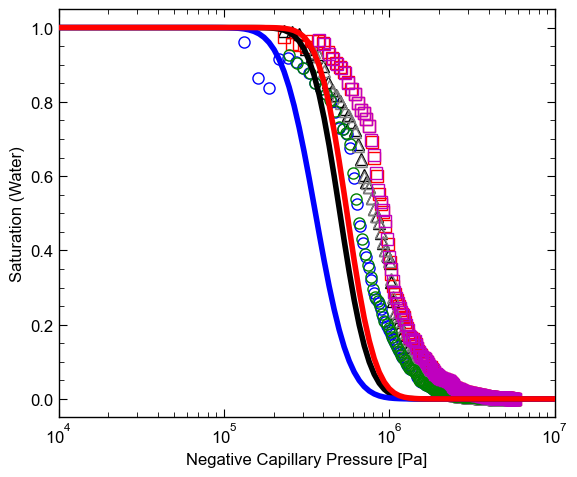

In [21]:
fig, ax = plt.subplots()

colors =['k','b','r']
shapes = ['^','o', 's']

secondary_colors = ['gray','g','m']

for s,sample in enumerate(drain_pcs):
    pc_data,sat_data,_ = average_curves_union(sample,drain_sats[s])
    ax.plot(pc_data,1-sat_data,' ',color=colors[s], marker=shapes[s], markerfacecolor='none')

for s,sample in enumerate(drain_pcs):
    pc_data,sat_data,_ = average_curves(sample,drain_sats[s])
    ax.plot(pc_data,1-sat_data,' ',color=secondary_colors[s], marker=shapes[s], markerfacecolor='none')



for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]/2
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*1,s,color=line_colors[i], linewidth=4,zorder=200)

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**7, 10**4])
ax.invert_xaxis()
plt.tick_params(axis='x', which='minor')
plt.title('')


# Trying to implement MixedInvasionPercolation

In [22]:
#Create OpenPNM project objects
pn_solid = []
pn_void = []

for x in snow_solid_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_solid.append(pn_temp)
    
for x in snow_void_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_void.append(pn_temp)
    

pn_total = [pn_solid, pn_void]


In [23]:
print(pn_total[0][0][0]['pore.extended_diameter'])

[1.2000e-07 1.0933e-07 6.9971e-08 ... 8.4853e-08 1.0392e-07 6.0000e-08]


In [24]:
#### This is what matches the V2 implementation/geometry

for s,sample in enumerate(pn_total[1]):
    for r,region in enumerate(sample):

        h = op.utils.check_network_health(region)
        op.topotools.trim(network=region, pores=h['disconnected_pores'])
        region.regenerate_models()

        region['pore.diameter'] = region['pore.extended_diameter']
        region['throat.diameter'] = region['throat.inscribed_diameter']
        region['pore.volume'] = op.models.geometry.pore_volume.sphere(region,pore_diameter='pore.equivalent_diameter')

        conduit_lengths = op.models.geometry.conduit_lengths.cones_and_cylinders(region)
        region['throat.length'] = conduit_lengths[:,1]
        region['throat.volume'] = op.models.geometry.throat_volume.cylinder(region)

        region.regenerate_models()

In [25]:
#### testing

# for s,sample in enumerate(pn_total[1]):
#     for r,region in enumerate(sample):

#         h = op.utils.check_network_health(region)
#         op.topotools.trim(network=region, pores=h['disconnected_pores'])
#         region.regenerate_models()

#         region['pore.diameter'] = region['pore.equivalent_diameter']
#         region['throat.diameter'] = region['throat.inscribed_diameter']
#         region['pore.volume'] = op.models.geometry.pore_volume.sphere(region,pore_diameter='pore.equivalent_diameter')
        
#         region.add_model(propname='throat.coords',model=op.models.geometry.throat_centroid.pore_coords)

#         conduit_lengths = op.models.geometry.conduit_lengths.hybrid_cones_and_cylinders(region)
#         region['throat.length'] = conduit_lengths[:,1]
#         region['throat.volume'] = op.models.geometry.throat_volume.cylinder(region)

#         region.regenerate_models()

In [26]:
region = pn_total[1][0][0]
print(region['throat.volume'])

[5.4736e-24 1.4703e-30 2.0358e-30 ... 9.0478e-31 1.0179e-30 9.0478e-31]


In [27]:
phases = []       
for s,sample in enumerate(pn_total[1]):
        sample_phases = []
        for r,region in enumerate(sample):
                phase = op.phase.Phase(network=region, name='phase_{}_{}'.format(s,r))
                phase['pore.contact_angle'] =  75  
                phase['pore.surface_tension'] = 0.0626 
                # phase['throat.contact_angle'] =  75
                # phase['throat.surface_tension'] = 0.0626

                # phase.add_model_collection(op.models.collections.phase.water)
                # phase.add_model_collection(op.models.collections.physics.basic)


                phase.add_model(propname='throat.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                                surface_tension='throat.surface_tension',
                                contact_angle='throat.contact_angle',
                                diameter='throat.diameter'
                                )
                phase.add_model(propname='pore.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                                surface_tension='pore.surface_tension',
                                contact_angle='pore.contact_angle',
                                diameter='pore.diameter'
                                )
                phase.regenerate_models()

                sample_phases.append(phase)
        phases.append(sample_phases)



In [28]:

import mixed_invasion_percolation_KF as mip
import importlib
 
importlib.reload(mip)
from mixed_invasion_percolation_KF import MixedInvasionPercolation

MIP = []
for s,sample in enumerate(pn_total[1]):
    sample_MIP = []
    for r, region in enumerate(sample):

        inlets = region.pores('ymax')
        used_inlets = [inlets[y] for y in range(0, len(inlets), 2)]
        MixedInvasionPercolation(network=region,phase=phases[s][r]).reset()
        perc = MixedInvasionPercolation(network=region,phase=phases[s][r],
                                        # name='mip_{}_{}'.format(s,r)
                                        )
        perc.setup(phase=phases[s][r])

        perc.set_inlet_BC(pores = used_inlets)
        perc.run()


        sample_MIP.append(perc)
    MIP.append(sample_MIP)



In [29]:
# pc = perc.pc_curve().pc
# sat = perc.pc_curve().S_tot

In [30]:
print(MIP[0][0]['pore.invasion_sequence'])
print(MIP[0][0]['pore.invasion_pressure'])
print(MIP[0][0])

[2759 2757 4892 ...  111 2179   88]
[ -619501.6903  -619501.6903  -197468.8124 ...  -926210.8533  -664779.0518
 -1080138.1482]

══════════════════════════════════════════════════════════════════════════════
mip_02 : <mixed_invasion_percolation_KF.MixedInvasionPercolation at 0x17b69de90>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.invasion_pressure                                        1669 / 1669
  3  throat.invasion_pressure                                      3281 / 3281
  4  pore.invasion_sequence                                        1669 / 1669
  5  throat.invasion_sequence                                      3281 / 3281
  6  pore.cluster                                                  1669 / 1669
  7  throat.cluster                                                3281 / 3281
 

In [31]:

mip_pcs = []
mip_sats = []
for s,sample in enumerate(MIP):
    sample_pcs = []
    sample_sats = []
    for r,region in enumerate(sample):
        region_pc = []
        region_sat_tot = []

        pc = region.pc_curve().pc
        sat = region.pc_curve().S_tot

        region_sat_tot.append(sat[0]) 
        region_pc.append(pc[0])
        for i,x in enumerate(sat):
            if  sat[i] - region_sat_tot[-1] > 0.0:
                region_pc.append(pc[i])
                region_sat_tot.append(sat[i])
        sample_pcs.append(region_pc)
        sample_sats.append(region_sat_tot)
    mip_pcs.append(sample_pcs)
    mip_sats.append(sample_sats)

In [32]:
print(len(MIP))
print(mip_pcs[0][0])

3
[-2700345.3705696333, -2415262.2890668456, -1909432.5557540345, -1800230.2470464222, -1559045.154585441, -1497882.1204889335, -1443395.272719773, -1309859.9361868384, -1272955.0729367202, -1239003.3806186856, -1207631.1445334228, -1178527.3128390945, -1151431.1104249519, -1080138.1482278535, -1059162.5923534555, -1039363.4602352029, -1002883.1064961028, -853924.1736537353, -805087.4583028379, -796288.401234211, -771527.2487341809, -763773.0094253635, -748941.0602444668, -741841.9266210889, -734940.9178971484, -715338.981135257, -709145.427339943, -703110.0534413565, -691487.580508674, -685888.4250080253, -675086.3426424083, -669873.2411447094, -664779.0517795318, -659799.4229709979, -654929.9680934192, -650166.793750268, -645506.0260440477, -636477.5364683601, -632103.0591324545, -627817.5336601314, -623618.018913344, -619501.6903093428, -615465.8339848791, -611507.8413096498, -603815.5722667114, -600076.7490154741, -596406.4906680647, -592802.8226768194, -589263.6564195473, -585787.

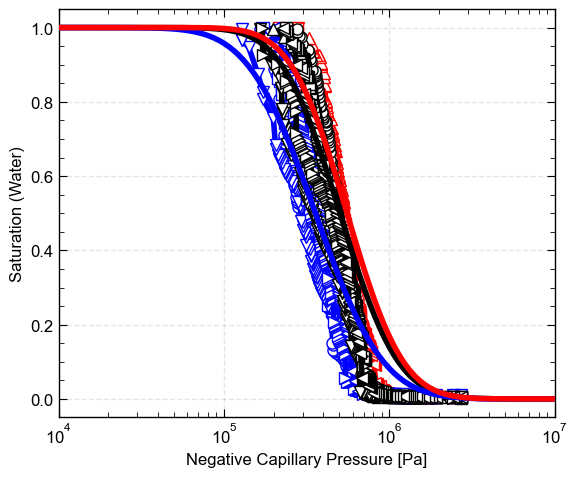

In [33]:
fig, ax = plt.subplots()

line_colors =['k','b','r']
shapes = ['^','o','s','v','>','<']
zorders = [100,99,98]

for s,sample in enumerate(mip_pcs):
    for r,region in enumerate(sample):
        # if s==1 and r==4:
        if True:
            # ax.plot(region,1-np.array(perc_sats[s][r]),color = line_colors[s], marker = shapes[r], 
            #         markeredgewidth=0.5, markerfacecolor='white',zorder=zorders[s])
            ax.plot(np.array(mip_pcs[s][r])*-1,np.array(mip_sats[s][r]),linewidth=4,color = line_colors[s], marker = shapes[r], 
                    markeredgewidth=1,markersize=8, markerfacecolor='white',zorder=zorders[s])


pcap = np.logspace(4,7,100)*-1
gamma = 0.0626
theta = 75

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap
for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*-1,s,color=line_colors[i], linewidth=4,zorder=200)

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**4, 10**7])

ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='minor')



In [34]:
#interpolation to average water retention curves for each sample across regions

x_interp = []
y_interp = []

x_all = []
f_avg = []

for s,sample in enumerate(mip_pcs):
    sample_x_data = []
    sample_y_data = []
    sample_x_min_vals = []
    sample_x_max_vals = []
    sample_interp_funcs = []
    for r,region in enumerate(sample):
        sample_x_data.append(region)
        sample_y_data.append(mip_sats[s][r])
        sample_x_max_vals.append(max(region))
        sample_x_min_vals.append(min(region))
        sample_interp_funcs.append(interp1d(region, mip_sats[s][r]))
        
    x_max = math.floor(min(sample_x_max_vals))
    x_min = math.ceil(max(sample_x_min_vals))
    
    # define common carrier for calculation of average curve
    sample_x_all   = np.geomspace(x_min, x_max, num=50)
    
    sample_f_int = []
    for r,region in enumerate(sample):
        # evaluation of fits on common carrier
        sample_f_int.append(sample_interp_funcs[r](sample_x_all))
        
    # put all fits to one matrix for fast mean calculation
    data_collection = np.vstack(sample_f_int)

    # calculating mean value
    sample_f_avg = np.average(data_collection, axis=0)

    x_interp.append(sample_x_data)
    y_interp.append(sample_y_data)
    x_all.append(sample_x_all)
    f_avg.append(sample_f_avg)


Text(0.5, 1.0, '')

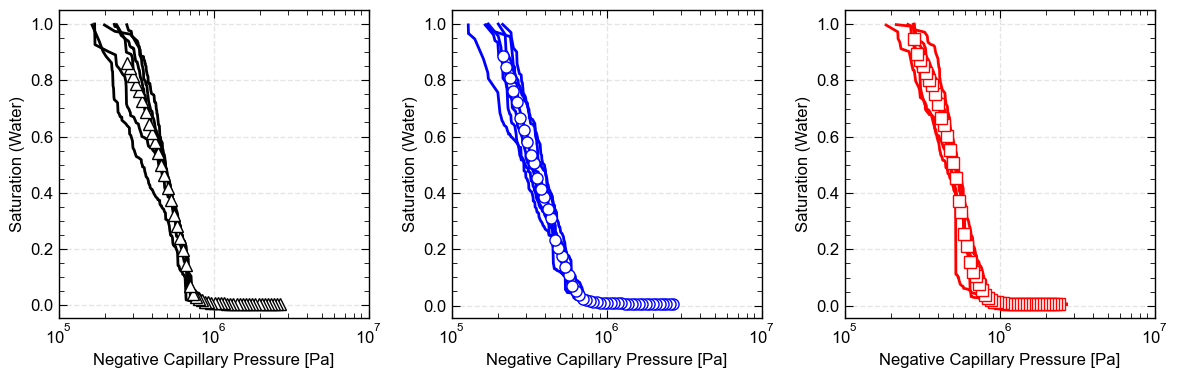

In [35]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

colors =['k','b','r']
shapes = ['^','o','s','v','>','<']


for s,sample in enumerate(mip_pcs):
    for r,region in enumerate(sample):
        axs[s].plot(np.array(mip_pcs[s][r])*-1,np.array(mip_sats[s][r]),linewidth=2,color = colors[s], 
                    )
            
for s,sample in enumerate(f_avg):
    axs[s].plot(x_all[s]*-1,np.array(f_avg[s]),' ',color=colors[s], marker=shapes[s],markersize=8, markerfacecolor='white')


# for s,sample in enumerate(mip_pcs):
#     pc_data,sat_data,_ = average_curves(sample,mip_sats[s])
#     axs[s].plot(pc_data*-1,sat_data,' ',color='m', marker=shapes[s],markersize=8, markerfacecolor='white')



for ax in axs:
    ax.set_xlabel("Negative Capillary Pressure [Pa]")
    ax.set_ylabel("Saturation (Water)")
    ax.set_xscale('log')
    ax.set_xlim([10**7, 10**5])
    ax.invert_xaxis()
    ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
    ax.tick_params(axis='x', which='minor')

plt.title('')


Text(0.5, 1.0, '')

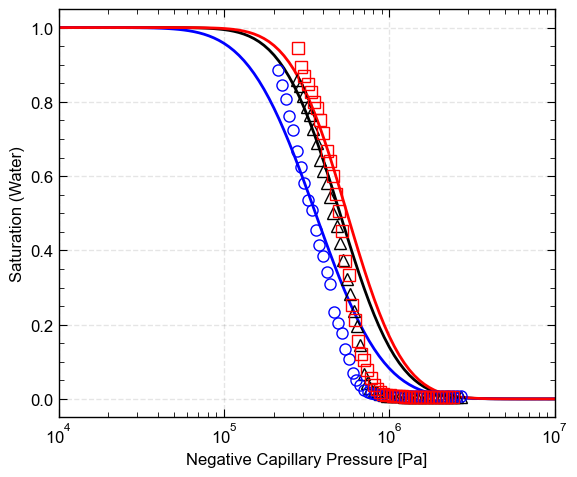

In [36]:
fig, ax = plt.subplots()

colors =['k','b','r']
shapes = ['^','o', 's']

for s,sample in enumerate(f_avg):
    ax.plot(x_all[s]*-1,np.array(f_avg[s]),' ',color=colors[s], marker=shapes[s], markerfacecolor='none',markersize=8,markeredgewidth=1,
            zorder=100)

pcap = np.logspace(4,7,100)*-1
gamma = 0.0626
theta = 75

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap
for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*-1,s,color=line_colors[i], linewidth=2,
            # zorder=200
            )

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**7, 10**4])
ax.invert_xaxis()
ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='minor')
plt.title('')


In [37]:
directory = 'data/water retention curves/'

pc_curve_Hegge = pd.read_csv(directory+'Hegge et al.csv',names=['pcap','sat'])
pc_curve_Kosakian = pd.read_csv(directory+'Kosakian.csv',names=['pcap','sat'])
pc_curve_Wrubel = pd.read_csv(directory+'Wrubel et al.csv',names=['pcap','sat'])
pc_curve_Ti_sinter = pd.read_csv(directory+'Ti sinter.csv',names=['pcap','sat'])


Text(0.5, 1.0, 'Comparison of water retention curves ($\\theta$ = 80$\\degree$)')

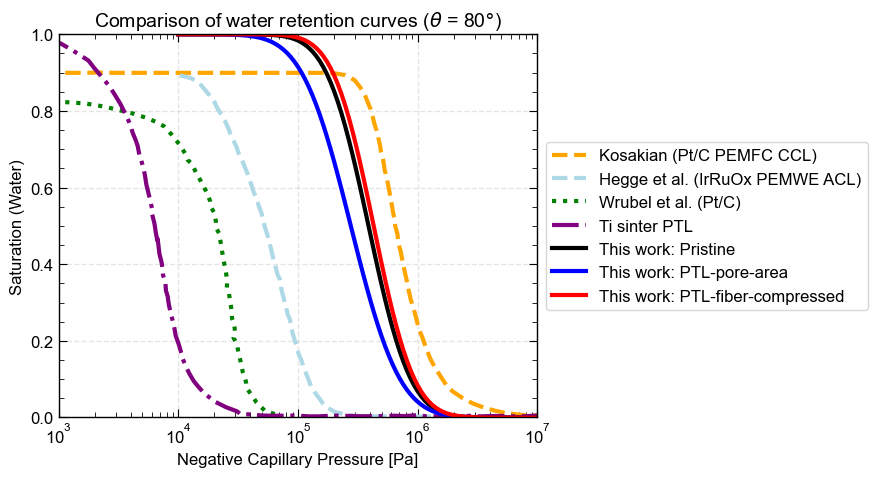

In [38]:
fig, ax = plt.subplots(figsize=(9,5))

colors =['k','b','r']
shapes = ['^','o', 's']
labels = ['Pristine','PTL-pore-area','PTL-fiber-compressed']


ax.plot(pc_curve_Kosakian.pcap,pc_curve_Kosakian.sat,'--',color='orange',linewidth=3,label='Kosakian (Pt/C PEMFC CCL)')
ax.plot(pc_curve_Hegge.pcap,pc_curve_Hegge.sat,'--',color='lightblue',linewidth=3,label='Hegge et al. (IrRuOx PEMWE ACL)')
ax.plot(pc_curve_Wrubel.pcap,pc_curve_Wrubel.sat,':',color='g',linewidth=3,label='Wrubel et al. (Pt/C)')
ax.plot(pc_curve_Ti_sinter.pcap,pc_curve_Ti_sinter.sat,'-.',color='purple',linewidth=3,label='Ti sinter PTL')

# for s,sample in enumerate(f_avg):
#     ax.plot(x_all[s]*-1,np.array(f_avg[s]),' ',color=colors[s], marker=shapes[s], markerfacecolor='none',markersize=8,
#             zorder=100)

pcap = np.logspace(4,7,100)*-1
gamma = 0.072
theta = 80

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap

for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*-1,s,color=line_colors[i], linewidth=3, label='This work: {}'.format(labels[i])
            # zorder=200
            )

ax.set_xlabel("Negative Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
ax.set_xlim([10**3, 10**7])
ax.set_ylim([0, 1])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='minor')
plt.title('Comparison of water retention curves ($\\theta$ = 80$\degree$)')


# Trying MIP with both 'water' and 'O2'

In [39]:
#Create OpenPNM project objects
pn_solid = []
pn_void = []

for x in snow_solid_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_solid.append(pn_temp)
    
for x in snow_void_networks:
    pn_temp = []
    for y in x:
        pn_temp.append(op.io.network_from_porespy(y))
    pn_void.append(pn_temp)
    

pn_total = [pn_solid, pn_void]


In [40]:
#### This is what matches the V2 implementation/geometry

for s,sample in enumerate(pn_total[1]):
    for r,region in enumerate(sample):

        h = op.utils.check_network_health(region)
        op.topotools.trim(network=region, pores=h['disconnected_pores'])
        region.regenerate_models()

        region['pore.diameter'] = region['pore.extended_diameter']
        region['throat.diameter'] = region['throat.inscribed_diameter']
        region['pore.volume'] = op.models.geometry.pore_volume.sphere(region,pore_diameter='pore.equivalent_diameter')

        conduit_lengths = op.models.geometry.conduit_lengths.cones_and_cylinders(region)
        region['throat.length'] = conduit_lengths[:,1]
        region['throat.volume'] = op.models.geometry.throat_volume.cylinder(region)

        region.regenerate_models()

In [41]:
phases_nw = []
phases_w = []

for s,sample in enumerate(pn_total[1]):
    sample_phases_nw = []
    sample_phases_w = []

    for r,region in enumerate(sample):

        phase_nw = op.phase.Phase(network=region,name='phase_nw_{}_{}'.format(s,r))
        phase_nw['pore.surface_tension'] = 0.0626
        phase_nw['throat.surface_tension'] = 0.0626
        phase_nw['pore.contact_angle'] =  100
        phase_nw['throat.contact_angle'] =  100
        phase_nw.add_model(propname='throat.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                        surface_tension='throat.surface_tension',
                        contact_angle='throat.contact_angle',
                        diameter='throat.diameter'
                        )
        phase_nw.add_model(propname='pore.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                        surface_tension='pore.surface_tension',
                        contact_angle='pore.contact_angle',
                        diameter='pore.diameter'
                        )
        phase_nw.regenerate_models()


        phase_w = op.phase.Phase(network=region,name='phase_w_{}_{}'.format(s,r))
        # phase_w.add_model_collection(op.models.collections.phase.water)
        phase_w['pore.surface_tension'] = 0.0626
        phase_w['throat.surface_tension'] = 0.0626
        phase_w['pore.contact_angle'] =  80 
        phase_w['throat.contact_angle'] =  80 
        phase_w.add_model(propname='throat.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                        surface_tension='throat.surface_tension',
                        contact_angle='throat.contact_angle',
                        diameter='throat.diameter'
                        )
        phase_w.add_model(propname='pore.entry_pressure',model=op.models.physics.capillary_pressure.washburn,
                        surface_tension='pore.surface_tension',
                        contact_angle='pore.contact_angle',
                        diameter='pore.diameter'
                        )
        phase_w.regenerate_models()

        sample_phases_nw.append(phase_nw)
        sample_phases_w.append(phase_w)

    phases_nw.append(sample_phases_nw)
    phases_w.append(sample_phases_w)


In [42]:

import mixed_invasion_percolation_KF as mip
import importlib
 
importlib.reload(mip)
from mixed_invasion_percolation_KF import MixedInvasionPercolation

MIP_w = []
MIP_nw = []
for s,sample in enumerate(pn_total[1]):
    sample_MIP_w = []
    sample_MIP_nw = []
    for r, region in enumerate(sample):
        inlets = region.pores('ymax')
        used_inlets = [inlets[y] for y in range(0, len(inlets), 2)]
        MixedInvasionPercolation(network=region,phase=phases_w[s][r]).reset()
        perc_w = MixedInvasionPercolation(network=region,phase=phases_w[s][r],
                                        # name='mip_w_{}_{}'.format(s,r)
                                        )
        perc_w.setup(phase=phases_w[s][r])
        perc_w.set_inlet_BC(pores = used_inlets)
        perc_w.run()
        sample_MIP_w.append(perc_w)

        inlets = region.pores('ymax')
        used_inlets = [inlets[y] for y in range(0, len(inlets), 2)]
        MixedInvasionPercolation(network=region,phase=phases_nw[s][r]).reset()
        perc_nw = MixedInvasionPercolation(network=region,phase=phases_nw[s][r],
                                        # name='mip_nw_{}_{}'.format(s,r)
                                        )
        perc_nw.setup(phase=phases_nw[s][r])
        perc_nw.set_inlet_BC(pores = used_inlets)
        perc_nw.run()
        sample_MIP_nw.append(perc_nw)

    MIP_w.append(sample_MIP_w)
    MIP_nw.append(sample_MIP_nw)

In [43]:
mip_w_pcs = []
mip_w_sats = []
for s,sample in enumerate(MIP_w):
    sample_pcs = []
    sample_sats = []
    for r,region in enumerate(sample):
        region_pc = []
        region_sat_tot = []

        pc = region.pc_curve().pc
        sat = region.pc_curve().S_tot

        region_sat_tot.append(sat[0]) 
        region_pc.append(pc[0])
        for i,x in enumerate(sat):
            if  sat[i] - region_sat_tot[-1] > 0.0:
                region_pc.append(pc[i])
                region_sat_tot.append(sat[i])
        sample_pcs.append(region_pc)
        sample_sats.append(region_sat_tot)
    mip_w_pcs.append(sample_pcs)
    mip_w_sats.append(sample_sats)

In [44]:
mip_nw_pcs = []
mip_nw_sats = []
for s,sample in enumerate(MIP_nw):
    sample_pcs = []
    sample_sats = []
    for r,region in enumerate(sample):
        region_pc = []
        region_sat_tot = []

        pc = region.pc_curve().pc
        sat = region.pc_curve().S_tot

        region_sat_tot.append(sat[0]) 
        region_pc.append(pc[0])
        for i,x in enumerate(sat):
            if  sat[i] - region_sat_tot[-1] > 0.0:
                region_pc.append(pc[i])
                region_sat_tot.append(sat[i])
        sample_pcs.append(region_pc)
        sample_sats.append(region_sat_tot)
    mip_nw_pcs.append(sample_pcs)
    mip_nw_sats.append(sample_sats)

In [45]:
print(mip_w_pcs[s][r])
print(mip_nw_pcs[s][r])

[-1811729.3203249741, -1620459.943038527, -1281086.1100011389, -1207819.546883316, -1004966.618587712, -968410.028178446, -905864.6601624871, -878817.8274426026, -854057.4306646457, -810229.9715192635, -790703.4821342056, -739635.370889289, -724691.7281299897, -710618.70250818, -697334.96903965, -672859.3863214984, -661549.9864107727, -640543.0550005694, -630763.1888845004, -621418.0519528913, -612476.2751458538, -603909.773441658, -595692.9126641633, -587802.6171493998, -572919.1086458667, -565889.158562689, -559111.8197482146, -552572.2750604602, -546256.9286442772, -540153.3335439505, -534249.8258459402, -523001.2147811277, -517636.9486642783, -512434.43536145677, -507385.69399122545, -502483.309293856, -497720.32279792294, -493090.26325767086, -484205.014089223, -479938.8330910981, -475783.4227757082, -471734.13931353885, -463936.3312196866, -460179.7176027238, -452932.33008124353, -449434.7297608746, -446016.91056753445, -442675.9529200123, -439408.9137213013, -436213.1807941883, 

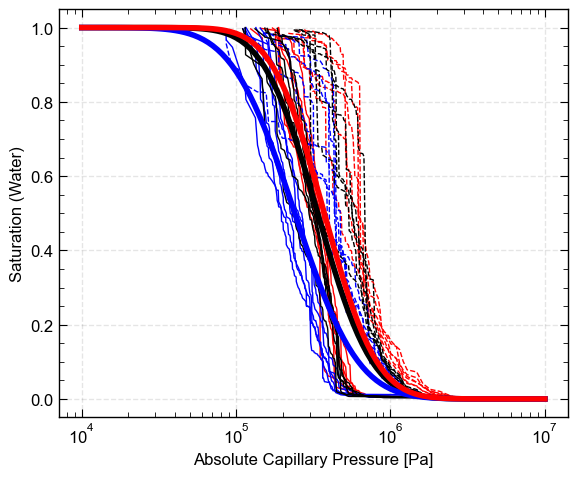

In [46]:
fig, ax = plt.subplots()

line_colors =['k','b','r']
shapes = ['^','o','s','v','>','<']
zorders = [100,99,98]

for s,sample in enumerate(mip_w_pcs):
    for r,region in enumerate(sample):
            ax.plot(np.array(mip_w_pcs[s][r])*-1,np.array(mip_w_sats[s][r]),'-',color = line_colors[s], linewidth=1,
                   zorder=zorders[s])
            ax.plot(np.array(mip_nw_pcs[s][r]),1-np.array(mip_nw_sats[s][r]),'--',color = line_colors[s], linewidth=1,
                    zorder=zorders[s])


pcap = np.logspace(4,7,100)*-1
gamma = 0.0626
theta = 80

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap
for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax.plot(pcap*-1,s,color=line_colors[i], linewidth=4,zorder=200)

ax.set_xlabel("Absolute Capillary Pressure [Pa]")
ax.set_ylabel("Saturation (Water)")
ax.set_xscale('log')
# ax.set_xlim([10**4, 10**7])
# ax.legend()

ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='minor')



# Attempting Weber permeability equation

(0.0, 1.0)

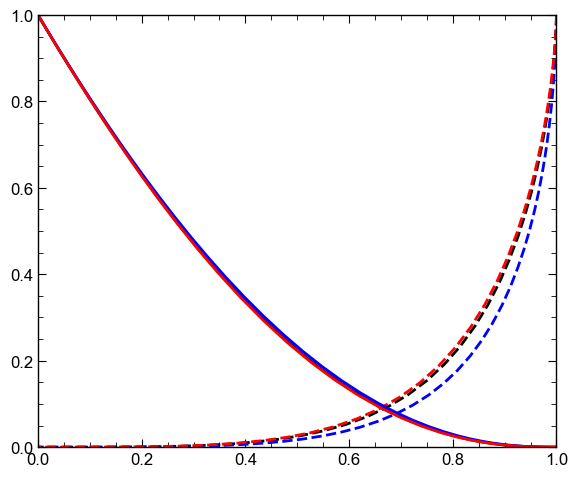

In [47]:
fig, ax = plt.subplots(figsize=(6,5))

colors =['k','b','r']
shapes = ['^','o', 's']
labels = ['Pristine','PTL-pore-area','PTL-fiber-compressed']


pcap = np.logspace(4,7,100)*-1
gamma = 0.0626
theta = 75

rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap
s_r = 0.01
s_0 = 0.8

for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))

    # s = s_r + s_star*(1-s_r) 
    s_e = (s-s_r)/(1-s_r)

    x = np.log(rcap/rk)/(sk*np.sqrt(2)) - sk*np.sqrt(2)
    k = s_e**2*0.5*(1+sp.special.erf(x))

    ax.plot(s,k,'--',color=line_colors[i], linewidth=2, 
            # zorder=200
            )
    
for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    # s = s_r + s_star*(s_0-s_r)

    x = np.log(rcap/rk)/(sk*np.sqrt(2)) - sk*np.sqrt(2)
    k_g = (1-s)**2*0.5*(1-sp.special.erf(x))


    ax.plot(s,k_g,color=line_colors[i], linewidth=2,
            # zorder=200
            )
    
s = np.linspace(0,1)
# ax.plot(s,s**5, ':')
# ax.plot(s,(1-s)**5, ':')

ax.set_xlim([0,1])
ax.set_ylim([0,1])
